In [16]:
try:
    if is_init:
        pass
except:
    %pwd
    %cd ..
    %pwd
    is_init = True

In [17]:
from pathlib import Path
from src.utils import FileUtils
from config import Config
from utils import rmse
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import altair as alt
from src.predictor import Predictor
data_folder = '../local_data'
work_folder = '../local_work'
configs_folder = '../configs'
results_folder = f'{work_folder}/saved_results'

In [18]:
#CHANGEME: model paths! 
I_INC_CKPT_PATH = '../local_work/saved_best/I-1-res-ann-inconel.ckpt' #../data/models/model.ckpt"
I_SS_CKPT_PATH = '../local_work/saved_best/I-1-res-ann-stainless.ckpt' #../data/models/model.ckpt"
D_INC_CKPT_PATH = '../local_work/saved_best/D-1-res-ann-inconel-2022-07-15_23-44.ckpt' #../data/models/model.ckpt"
D_SS_CKPT_PATH = '../local_work/saved_best/D-1-res-ann-stainless.ckpt' #../data/models/model.ckpt"

In [19]:
# read_file
# read_file = pd.read_csv('../src/notebooks/sample_input.csv')
# desired_emiss = interpolate(read_file) #torch.from_numpy(np.array(torch.randn(1, 800) * 3))

include_inconel = True #Change ME
include_stainless = True #Change ME
round_laser_params = True #Change Me


# for emiss in emiss_test:
predictor = Predictor(I_INC_CKPT_PATH, I_SS_CKPT_PATH,  D_INC_CKPT_PATH,  D_SS_CKPT_PATH, round_laser_params = True)

# def get_data( filepath, type):
#     stain_data = torch.load(
#                     Path(filepath))#["laser_params"] #stainless-inconel-revised-shuffled inconel-revised-raw-shuffled
#     wave_data = stain_data["interpolated_wavelength"]
#     emiss_data = stain_data["interpolated_emissivity"]
#     laser_params = stain_data["laser_params"]
#     uids = stain_data["uids"]
#     if type == 'test':
#         wave_test = wave_data[round(len(wave_data) * .9):]  
#         emiss_test = emiss_data[round(len(wave_data) * .9):]
#         laser_params = laser_params[round(len(wave_data) * .9):]
#         uids = uids[round(len(wave_data) * .9):]
#     elif type == 'trainval':
#         wave_test = wave_data[:round(len(wave_data) * .9)]  
#         emiss_test = emiss_data[:round(len(wave_data) * .9)]
#         laser_params = laser_params[:round(len(wave_data) * .9)]
#         uids = uids[:round(len(wave_data) * .9)]
#     else: 
#         wave_test = wave_data
#         emiss_test = emiss_data
#         laser_params = laser_params
    
#     return wave_test, emiss_test, laser_params, uids

inc_params = torch.load(
                Path(f"{data_folder}/inconel-onehot.pt"))["laser_params"]

if include_stainless:
    inconel_wave_test, steel_emiss_test, steel_laser_params_test, steel_uids_test = predictor.get_data(
        f"{data_folder}/stainless-onehot.pt", "test")
    steel_wave, steel_emiss, steel_laser_params, steel_uids = predictor.get_data(f"{data_folder}/stainless-onehot.pt", "full")
    steel_wave_train, steel_emiss_train, steel_laser_params_train, steel_uids_train = predictor.get_data(
        f"{data_folder}/stainless-onehot.pt", "train")
    steel_wave_val, steel_emiss_val, steel_laser_params_val, steel_uids_val = predictor.get_data(f"{data_folder}/stainless-onehot.pt", "val")
if include_inconel:
    inconel_wave, inconel_emiss, inconel_laser_params, inconel_uids = predictor.get_data(f"{data_folder}/inconel-onehot.pt", "full")
    inconel_wave_test, inconel_emiss_test, inconel_laser_params_test, inconel_uids_test = predictor.get_data(f"{data_folder}/inconel-onehot.pt", "test")
    inconel_wave_train, inconel_emiss_train, inconel_laser_params_train, inconel_uids_train = predictor.get_data(f"{data_folder}/inconel-onehot.pt", "train")
    inconel_wave_val, inconel_emiss_val, inconel_laser_params_val, inconel_uids_val = predictor.get_data(f"{data_folder}/inconel-onehot.pt", "val")

# max_speed, max_spacing = steel_laser_params.max(0)[0][0].item(), steel_laser_params.max(0)[0][1].item()
# min_speed, min_spacing = steel_laser_params.min(0)[0][0].item(), steel_laser_params.min(0)[0][1].item()

In [20]:
if include_stainless:
    #run inverse models
    y_hat_ss = predictor.run_model(steel_emiss_test, "steel", "inverse")
    # decode predictions from inverse model
    y_hat_ss_norm = predictor.denormalize_and_decode(y_hat_ss, "steel", False)
    ss_not_in_data, ss_same_params, ss_y_hat_in_data, ss_y_test = predictor.find_in_data(y_hat_ss_norm, 'steel')
    #run direct models on inverse output
    y_hat_emiss_ss = predictor.run_model(y_hat_ss, "steel", "direct")
    torch.save({"y_hat_in_data": ss_y_hat_in_data, "y_test": ss_y_test},
               Path(results_folder, 'stainless_results.pt'))

if include_inconel:
    y_hat_inc = predictor.run_model(inconel_emiss_test, "inconel", "inverse")
    y_hat_inc_norm = predictor.denormalize_and_decode(y_hat_inc, "inconel", False)
    inc_not_in_data, inc_same_params, inc_y_hat_in_data, inc_y_test = predictor.find_in_data(y_hat_inc_norm, 'inconel')
    y_hat_emiss_inc = predictor.run_model(y_hat_inc, "inconel", "direct")
    torch.save({"y_hat_in_data": inc_y_hat_in_data, "y_test": inc_y_test},
               Path(results_folder, 'inconel_results.pt'))


In [21]:
# run models on training and validation data

if include_stainless:
    #run inverse models
    y_hat_ss_train = predictor.run_model(steel_emiss_train, "steel", "inverse")
    y_hat_ss_val = predictor.run_model(steel_emiss_val, "steel", "inverse")
    # decode predictions from inverse model
    #y_hat_ss_norm = predictor.denormalize_and_decode(y_hat_ss, "steel", False)
    #ss_not_in_data, ss_same_params, ss_y_hat_in_data, ss_y_test = predictor.find_in_data(y_hat_ss_norm, 'steel')
    #run direct models on inverse output
    y_hat_emiss_ss_train = predictor.run_model(y_hat_ss_train, "steel", "direct")
    y_hat_emiss_ss_val = predictor.run_model(y_hat_ss_val, "steel", "direct")

    #run direct model on test data
    steel_laser_params_norm_train = predictor.denormalize_and_decode(steel_laser_params_train, "steel", normalize = "normalize", round_laser_params = False)
    steel_laser_params_norm_val = predictor.denormalize_and_decode(steel_laser_params_val, "steel", normalize = "normalize", round_laser_params = False)
    steel_laser_params_norm_test = predictor.denormalize_and_decode(steel_laser_params_test, "steel", normalize = "normalize", round_laser_params = False)

    direct_train = predictor.run_model(steel_laser_params_norm_train, "steel", "direct")
    direct_val = predictor.run_model(steel_laser_params_norm_val, "steel", "direct")
    direct_test = predictor.run_model(steel_laser_params_norm_test, "steel", "direct")
    # torch.save({"y_hat_in_data": ss_y_hat_in_data, "y_test": ss_y_test},
    #            Path(results_folder, 'stainless_results.pt'))
    train_mean_rmse, train_std_rmse = predictor.rmse_metrics(steel_emiss_train, y_hat_emiss_ss_train)
    val_mean_rmse, val_std_rmse = predictor.rmse_metrics(steel_emiss_val, y_hat_emiss_ss_val)
    test_mean_rmse, test_std_rmse = predictor.rmse_metrics(steel_emiss_test, y_hat_emiss_ss)
    #direct
    d_train_mean_rmse, d_train_std_rmse = predictor.rmse_metrics(steel_emiss_train, direct_train)
    d_val_mean_rmse, d_val_std_rmse = predictor.rmse_metrics(steel_emiss_val, direct_val)
    d_test_mean_rmse, d_test_std_rmse = predictor.rmse_metrics(steel_emiss_test, direct_test)
print('---STEEL INVERSE MODEL---')
print(f'TRAIN : Mean RMSE: {train_mean_rmse}, SD: {train_std_rmse}')
print(f'VAL Mean RMSE: {val_mean_rmse}, SD: {val_std_rmse}')
print(f'TEST Mean RMSE: {test_mean_rmse}, SD: {test_std_rmse}')

print('---STEEL DIRECT MODEL---')
print(f'TRAIN: Mean RMSE: {d_train_mean_rmse}, SD: {d_train_std_rmse}')
print(f'VAL Mean RMSE: {d_val_mean_rmse}, SD: {d_val_std_rmse}')
print(f'TEST Mean RMSE: {d_test_mean_rmse}, SD: {d_test_std_rmse}')
# if include_inconel:
#     y_hat_inc = predictor.run_model(inconel_emiss_test, "inconel", "inverse")
#     y_hat_inc_norm = predictor.denormalize_and_decode(y_hat_inc, "inconel", False)
#     inc_not_in_data, inc_same_params, inc_y_hat_in_data, inc_y_test = predictor.find_in_data(y_hat_inc_norm, 'inconel')
#     y_hat_emiss_inc = predictor.run_model(y_hat_inc, "inconel", "direct")
#     torch.save({"y_hat_in_data": inc_y_hat_in_data, "y_test": inc_y_test},
#                Path(results_folder, 'inconel_results.pt'))


---STEEL INVERSE MODEL---
TRAIN : Mean RMSE: 0.017260000109672546, SD: 0.013260000385344028
VAL Mean RMSE: 0.01711999997496605, SD: 0.014089999720454216
TEST Mean RMSE: 0.017650000751018524, SD: 0.01413000002503395
---STEEL DIRECT MODEL---
TRAIN: Mean RMSE: 0.009589999914169312, SD: 0.011409999802708626
VAL Mean RMSE: 0.01257999986410141, SD: 0.014619999565184116
TEST Mean RMSE: 0.013240000233054161, SD: 0.0188400000333786


In [23]:
# run models on training and validation data

if include_inconel:
    #run inverse models
    y_hat_inc_train = predictor.run_model(inconel_emiss_train, "inconel", "inverse")
    y_hat_inc_val = predictor.run_model(inconel_emiss_val, "inconel", "inverse")
    # decode predictions from inverse model
    #y_hat_ss_norm = predictor.denormalize_and_decode(y_hat_ss, "steel", False)
    #ss_not_in_data, ss_same_params, ss_y_hat_in_data, ss_y_test = predictor.find_in_data(y_hat_ss_norm, 'steel')
    #run direct models on inverse output
    y_hat_emiss_inc_train = predictor.run_model(y_hat_inc_train, "inconel", "direct")
    y_hat_emiss_inc_val = predictor.run_model(y_hat_inc_val, "inconel", "direct")

    #run direct model on test data
    inconel_laser_params_norm_train = predictor.denormalize_and_decode(inconel_laser_params_train, "inconel", normalize = "normalize", round_laser_params = False)
    inconel_laser_params_norm_val = predictor.denormalize_and_decode(inconel_laser_params_val, "inconel", normalize = "normalize", round_laser_params = False)
    inconel_laser_params_norm_test = predictor.denormalize_and_decode(inconel_laser_params_test, "inconel", normalize = "normalize", round_laser_params = False)

    direct_train = predictor.run_model(inconel_laser_params_norm_train, "inconel", "direct")
    direct_val = predictor.run_model(inconel_laser_params_norm_val, "inconel", "direct")
    direct_test = predictor.run_model(inconel_laser_params_norm_test, "inconel", "direct")
    # torch.save({"y_hat_in_data": ss_y_hat_in_data, "y_test": ss_y_test},
    #            Path(results_folder, 'stainless_results.pt'))
    train_mean_rmse, train_std_rmse = predictor.rmse_metrics(inconel_emiss_train, y_hat_emiss_inc_train)
    val_mean_rmse, val_std_rmse = predictor.rmse_metrics(inconel_emiss_val, y_hat_emiss_inc_val)
    test_mean_rmse, test_std_rmse = predictor.rmse_metrics(inconel_emiss_test, y_hat_emiss_inc)
    #direct
    d_train_mean_rmse, d_train_std_rmse = predictor.rmse_metrics(inconel_emiss_train, direct_train)
    d_val_mean_rmse, d_val_std_rmse = predictor.rmse_metrics(inconel_emiss_val, direct_val)
    d_test_mean_rmse, d_test_std_rmse = predictor.rmse_metrics(inconel_emiss_test, direct_test)
print('---INCONEL INVERSE MODEL---')
print(f'TRAIN : Mean RMSE: {train_mean_rmse}, SD: {train_std_rmse}')
print(f'VAL Mean RMSE: {val_mean_rmse}, SD: {val_std_rmse}')
print(f'TEST Mean RMSE: {test_mean_rmse}, SD: {test_std_rmse}')

print('---INCONEL DIRECT MODEL---')
print(f'TRAIN: Mean RMSE: {d_train_mean_rmse}, SD: {d_train_std_rmse}')
print(f'VAL Mean RMSE: {d_val_mean_rmse}, SD: {d_val_std_rmse}')
print(f'TEST Mean RMSE: {d_test_mean_rmse}, SD: {d_test_std_rmse}')
# if include_inconel:
#     y_hat_inc = predictor.run_model(inconel_emiss_test, "inconel", "inverse")
#     y_hat_inc_norm = predictor.denormalize_and_decode(y_hat_inc, "inconel", False)
#     inc_not_in_data, inc_same_params, inc_y_hat_in_data, inc_y_test = predictor.find_in_data(y_hat_inc_norm, 'inconel')
#     y_hat_emiss_inc = predictor.run_model(y_hat_inc, "inconel", "direct")
#     torch.save({"y_hat_in_data": inc_y_hat_in_data, "y_test": inc_y_test},
#                Path(results_folder, 'inconel_results.pt'))


---INCONEL INVERSE MODEL---
TRAIN : Mean RMSE: 0.01498000044375658, SD: 0.012070000171661377
VAL Mean RMSE: 0.015159999951720238, SD: 0.012400000356137753
TEST Mean RMSE: 0.015180000104010105, SD: 0.012350000441074371
---INCONEL DIRECT MODEL---
TRAIN: Mean RMSE: 0.039069999009370804, SD: 0.05626999959349632
VAL Mean RMSE: 0.041349999606609344, SD: 0.0604499988257885
TEST Mean RMSE: 0.038589999079704285, SD: 0.05689999833703041


In [25]:
test_emiss = inconel_emiss_test #CHANGEME: Options: steel_emiss_test, inconel_emiss_test

#run ensemble prediction
ensemble_preds = []
ensemble_predictor = Predictor(I_INC_CKPT_PATH, I_SS_CKPT_PATH,  D_INC_CKPT_PATH,  D_SS_CKPT_PATH, round_laser_params = True)
#run inverse models
e_y_hat_ss = predictor.run_model(test_emiss, "steel", "inverse")
# decode predictions from inverse model
#e_y_hat_ss_norm = predictor.denormalize_and_decode(y_hat_ss, "steel", False)
#e_ss_not_in_data, e_ss_same_params, e_ss_y_hat_in_data, e_ss_y_test = predictor.find_in_data(e_y_hat_ss_norm, 'steel')
#run direct models on inverse output
e_y_hat_emiss_ss = predictor.run_model(e_y_hat_ss, "steel", "direct")

e_y_hat_inc = predictor.run_model(test_emiss, "inconel", "inverse")
#e_y_hat_inc_norm = predictor.denormalize_and_decode(e_y_hat_inc, "inconel", False)
#e_inc_not_in_data, e_inc_same_params, e_inc_y_hat_in_data, e_inc_y_test = predictor.find_in_data(e_y_hat_inc_norm, 'inconel')
e_y_hat_emiss_inc = predictor.run_model(e_y_hat_inc, "inconel", "direct")

#substrate, rmse = predictor.best_predictor(True, True, y_hat_emiss_ss[0], y_hat_emiss_inc[0], steel_emiss_test[0])
for i in range(len(test_emiss)):
    substrate, rmses = predictor.best_predictor(True, True, e_y_hat_emiss_ss[i], e_y_hat_emiss_inc[i], test_emiss[i])
    ensemble_preds.append([substrate, rmses, i])
ensemble_preds
#watt_arg = torch.argmax(y_hat[:, 2:], axis=1)

[['inconel', 0.008156719617545605, 0],
 ['inconel', 0.022191673517227173, 1],
 ['inconel', 0.013456842862069607, 2],
 ['inconel', 0.02334286831319332, 3],
 ['inconel', 0.01783294975757599, 4],
 ['inconel', 0.003425312926992774, 5],
 ['inconel', 0.0052248649299144745, 6],
 ['inconel', 0.008470026776194572, 7],
 ['inconel', 0.004874903708696365, 8],
 ['inconel', 0.019047457724809647, 9],
 ['inconel', 0.00725373113527894, 10],
 ['stainless', 0.006316095590591431, 11],
 ['inconel', 0.008356110192835331, 12],
 ['stainless', 0.011073396541178226, 13],
 ['inconel', 0.04472671449184418, 14],
 ['inconel', 0.010592326521873474, 15],
 ['inconel', 0.004936147015541792, 16],
 ['inconel', 0.009641439653933048, 17],
 ['inconel', 0.013749812729656696, 18],
 ['inconel', 0.012715006247162819, 19],
 ['inconel', 0.008411778137087822, 20],
 ['inconel', 0.006497550755739212, 21],
 ['inconel', 0.02011973224580288, 22],
 ['stainless', 0.017732011154294014, 23],
 ['inconel', 0.021002819761633873, 24],
 ['incon

In [26]:
e_preds = np.array(ensemble_preds)
total = len(ensemble_preds)
steel_count = len(e_preds[e_preds[:,0] == 'stainless'])
inconel_count = len(e_preds[e_preds[:,0] == 'inconel'])
print('---ENSEMBLE---')
print(f'% Steel: {steel_count / total}, % Inconel: {inconel_count / total}')
e_rmses = e_preds[:,1].astype('float')
print(f'Ensemble Mean RMSE: {np.mean(e_rmses)}')
print(f'Ensemble SD RMSE: {np.std(e_rmses)}')

---ENSEMBLE---
% Steel: 0.16156462585034015, % Inconel: 0.8384353741496599
Ensemble Mean RMSE: 0.013220148802129869
Ensemble SD RMSE: 0.009002122373360032


In [27]:
#Model No Rounding RMSE Results
model_mean_rmse, model_std_rmse = predictor.rmse_metrics(steel_emiss_test, y_hat_emiss_ss)
print('---STEEL MODEL---')
print(f'Mean RMSE: {model_mean_rmse}, SD: {model_std_rmse}')

#Model No Rounding RMSE Results
i_model_mean_rmse, i_model_std_rmse = predictor.rmse_metrics(inconel_emiss_test, y_hat_emiss_inc)
print('---INCONEL MODEL---')
print(f'Mean RMSE: {i_model_mean_rmse}, SD: {i_model_std_rmse}')


---STEEL MODEL---
Mean RMSE: 0.017650000751018524, SD: 0.01413000002503395
---INCONEL MODEL---
Mean RMSE: 0.015180000104010105, SD: 0.012350000441074371


In [28]:
y_hat = y_hat_ss_norm

print(len(ss_not_in_data))
print(len(ss_same_params))
print(len(ss_y_test["laser_params"]))

567
5
2466


In [29]:
# RMSE SCORES FOR ROUNDED PREDICTIONS FOUND IN DATA

# Stainless Manufactured Predictions
mean_rmse, stdev_rmse = predictor.rmse_metrics(ss_y_hat_in_data["emissivity"], ss_y_test["emissivity"], decimals = 5)
print(f'Mean RMSE: {mean_rmse}, SD: {stdev_rmse}')
# RMSE SCORES FOR ROUNDED PREDICTIONS FOUND IN DATA
# Inconel Manufactured Predictions
inc_mean_rmse, inc_stdev_rmse = predictor.rmse_metrics(inc_y_hat_in_data["emissivity"], inc_y_test["emissivity"], decimals = 5)
print(f'Mean RMSE: {mean_rmse}, SD: {stdev_rmse}')


Mean RMSE: 0.026040000841021538, SD: 0.018459999933838844


In [30]:
#Clean up parameters out of data and 'send_to_lab'  #DO NOT TOUCH
send_to_lab, size_unique, size_total = predictor.clean_and_send_to_lab(ss_not_in_data)
print(f'Total # of Preds: {size_total}, Unique # of Preds: {size_unique}')

Total # of Preds: 567, Unique # of Preds: 96


## SAD Metric Analysis

In [31]:
#compute SAD between parameters
y_hat_params, test_params, sad_values, rmses, y_hat_uids, test_uids = predictor.SAD(ss_y_hat_in_data, ss_y_test, "steel")


In [32]:
#create DF comparing laser parameters, SAD, and RMSE
columns = ['Pred UID', 'speed_pred', 'spacing_pred', 'power_pred', 'Test UID', 'speed_test', 'spacing_test', 'power_test', 'SAD', 'RMSE']
sad_df = pd.DataFrame(torch.cat((y_hat_uids, y_hat_params, test_uids, test_params, sad_values, rmses), dim = 1).numpy(), columns = columns)

In [33]:
sad_df[['SAD']].describe()

SAD
count  2466.000000
mean      0.810526
std       0.422367
min       0.014493
25%       0.492259
50%       0.771386
75%       1.100530
max       2.160233

In [34]:
alt.Chart(sad_df).mark_circle(size=15).encode(
    y=alt.Y('RMSE'),
    x=alt.X('speed_pred', title="Predicted Speed (mm/s)", scale=alt.Scale(domain=[10,700])),
).properties(title = 'RMSE vs. Speed')


alt.Chart(...)

In [35]:
alt.Chart(sad_df).mark_circle(size=15).encode(
    y=alt.Y('RMSE'),
    x=alt.X('spacing_pred', title="Predicted Spacing (um)", scale=alt.Scale(domain=[1,42])),
).properties(title = 'RMSE vs Spacing')


alt.Chart(...)

In [36]:
alt.Chart(sad_df).mark_circle(size=15).encode(
    y=alt.Y('RMSE'),
    x=alt.X('power_pred', title="Predicted Power (W)", scale=alt.Scale(domain=[.1,1.3])),
).properties(title = 'RMSE vs Power')


alt.Chart(...)

In [40]:
chart = alt.Chart(sad_df).mark_circle(size=15).encode(
    x='RMSE',
    y='SAD',
).properties(title = 'RMSE vs SAD')
chart# + chart.transform_regression('RMSE', 'SAD').mark_line()

alt.Chart(...)

In [ ]:
alt.Chart(sad_df).mark_circle(size=60).encode(
    x='RMSE',
    y='SAD',
    color='spacing_pred'
).properties(title = 'RMSE vs SAD')


alt.Chart(...)

In [50]:
#look at subset of predictions
#sad_df[(sad_df['SAD'] > .77) & (sad_df['SAD'] < .79)]
sad_df[sad_df['RMSE'] < .004]#["Pred UID"].tolist()#[]

Pred UID  speed_pred  spacing_pred  power_pred  Test UID  speed_test  \
94     21130.0       280.0          35.0         0.7   31891.0       130.0   
206    16206.0       470.0          34.0         0.7   32050.0       510.0   
208    25539.0       400.0          39.0         0.7   32053.0       530.0   
401    21603.0       430.0          39.0         0.7   32316.0       700.0   
504    17939.0       460.0          35.0         0.7   32466.0       570.0   
975    24828.0       440.0          37.0         0.7   33132.0       500.0   
1117   12288.0        70.0          36.0         0.6   33348.0        80.0   
1126   23254.0       470.0          38.0         0.7   33360.0       490.0   
1240   27812.0       470.0          36.0         0.7   33520.0       440.0   
1301   23254.0       470.0          38.0         0.7   33612.0       690.0   
1347   25539.0       400.0          39.0         0.7   33681.0       120.0   
1573   23880.0       450.0          38.0         0.7   34005.0       610.0   
1655   33906.0        90.0          22.0         0.6   34114.0       100.0   
1934   33968.0       480.0          36.0         0.7   34530.0       600.0   
1995   17939.0       460.0          35.0         0.7   34618.0       490.0   
2167    1880.0       480.0          38.0         0.7   34873.0       490.0   
2338   27694.0       410.0          39.0         0.7   35099.0       570.0   

      spacing_test  power_test       SAD      RMSE  
94            32.0         0.3  0.690562  0.003969  
206           30.0         0.7  0.155532  0.001912  
208           30.0         0.4  0.707918  0.003759  
401           28.0         0.7  0.659597  0.002790  
504           29.0         0.9  0.505762  0.002791  
975           31.0         0.6  0.333298  0.003095  
1117          36.0         0.7  0.114493  0.002157  
1126          15.0         0.3  0.989961  0.003603  
1240          35.0         0.5  0.267869  0.003125  
1301          38.0         0.7  0.318841  0.001728  
1347          35.0         0.2  1.003358  0.001745  
1573          38.0         1.1  0.631884  0.003980  
1655          20.0         0.6  0.063273  0.002550  
1934          29.0         0.4  0.644645  0.003897  
1995          35.0         0.8  0.143478  0.002958  
2167          41.0         0.6  0.187663  0.003475  
2338          25.0         0.7  0.573348  0.003213

In [ ]:
comparison_UID = list(sad_df[sad_df['RMSE'] > .14][["Pred UID", "Test UID"]].itertuples(index = False, name = None))
comparison_UID

[(1307.0, 32705.0), (1307.0, 33634.0), (1307.0, 34081.0), (31595.0, 34292.0)]

In [ ]:
#calculate rmse between rounded predictions
pred_rmse_vals = []
columns = ["wavelength", "emissivity", "prediction", "example_number", "laser_params"]
viz_coords = pd.DataFrame(columns = columns)
graph_num = 0
for i, k in comparison_UID:#len(emiss_test)):
    index_i = (steel_uids == i).nonzero()[0].item()
    index_k = (steel_uids == k).nonzero()[0].item()
    curr_rmse = rmse(steel_emiss[index_i], steel_emiss[index_k]).item()
    graph_title = f'RMSE: {round(curr_rmse, 4)},Pred Params:({steel_laser_params[index_i][0]},{steel_laser_params[index_i][1]},{steel_laser_params[index_i][2]}), Test Params:({steel_laser_params[index_k][0]},{steel_laser_params[index_k][1]},{steel_laser_params[index_k][2]})'
    for j in range(steel_wave.shape[1]):
        pd1 = pd.DataFrame([[steel_wave[index_i][j].item(), steel_emiss[index_i][j].item(), "pred", graph_num, graph_title]], columns = columns)
        pd2 = pd.DataFrame([[steel_wave[index_k][j].item(), steel_emiss[index_k][j].item(), "test", graph_num, graph_title]], columns = columns)
        viz_coords = pd.concat([viz_coords,pd1, pd2])
    graph_num += 1
stdev = np.std(pred_rmse_vals)
print(f'SD of RMSEs on test data: {stdev}')


SD of RMSEs on test data: nan


/home/spencersong/anaconda3/envs/meta/lib/python3.10/site-packages/numpy/core/_methods.py:264: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/spencersong/anaconda3/envs/meta/lib/python3.10/site-packages/numpy/core/_methods.py:222: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/home/spencersong/anaconda3/envs/meta/lib/python3.10/site-packages/numpy/core/_methods.py:256: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [60]:
#calculate worst N predictions rmse
n_scores = []
n = 3
for i in range(len(steel_emiss_test)):
    n_scores.append(rmse(y_hat_emiss_ss[i], steel_emiss_test[i]))
worst_n = np.argsort(n_scores)[-n:]
best_n = np.argsort(n_scores)[:n]
print(worst_n)

pred_rmse_vals = []
columns = ["wavelength", "emissivity", "prediction", "example_number", "laser_params"]
viz_n = pd.DataFrame(columns = columns)
steel_clean_params_test = predictor.denormalize_and_decode(steel_laser_params_test, "steel", True, "no", False)
for i in worst_n:#len(emiss_test)):
    for j in range(len(steel_wave_test[i].tolist())): 
        graph_title = f"Speed: {steel_clean_params_test[i][0]}, Spacing: {steel_clean_params_test[i][1]}, Wattage: {np.round(steel_clean_params_test[i][2].item(), 1)}, RMSE: {np.around(n_scores[i].item(), 4)}"
        pd1 = pd.DataFrame([[steel_wave_test[i][j].item(), steel_emiss_test[i][j].item(), "True", i, graph_title]], columns = columns)
        pd2 = pd.DataFrame([[steel_wave_test[i][j].item(), y_hat_emiss_ss[i][j].item(), "Prediction", i, graph_title]], columns = columns)
        viz_n = pd.concat([viz_n,pd1, pd2])
        #viz_coords.append([wave_test[i].tolist()[j], emiss_test[i].tolist()[j], "True", i, laser_output[i].tolist()])
        #viz_coords.append([wave_test[i].tolist()[j], emiss_y_hats[i].flatten().tolist()[j], "Prediction", i, laser_output[i].tolist()])


[2147  946 2192]


In [74]:
#calculate difference between curves heatmap
n_scores = []
for i in range(len(steel_emiss_test)):
    n_scores.append(rmse(y_hat_emiss_ss[i], steel_emiss_test[i]))

pred_rmse_vals = []
columns = ["wavelength", "difference", "example_number"]
viz_diff = pd.DataFrame(columns = columns)
#steel_clean_params_test = predictor.denormalize_and_decode(steel_laser_params_test, "steel", True, "no", False)
for i in np.argsort(n_scores)[-200:]:#len(emiss_test)):
    for j in range(len(steel_wave_test[i].tolist())): 
        #graph_title = f"Speed: {steel_clean_params_test[i][0]}, Spacing: {steel_clean_params_test[i][1]}, Wattage: {np.round(steel_clean_params_test[i][2].item(), 1)}, RMSE: {np.around(n_scores[i].item(), 4)}"
        pd1 = pd.DataFrame([[steel_wave_test[i][j].item(), y_hat_emiss_ss[i][j].item() - steel_emiss_test[i][j].item(), i]], columns = columns)
        viz_diff = pd.concat([viz_diff,pd1])
        #viz_coords.append([wave_test[i].tolist()[j], emiss_test[i].tolist()[j], "True", i, laser_output[i].tolist()])
        #viz_coords.append([wave_test[i].tolist()[j], emiss_y_hats[i].flatten().tolist()[j], "Prediction", i, laser_output[i].tolist()])


KeyboardInterrupt: 

In [75]:
#steel_wave_test[1][1].item()
viz_diff

wavelength difference example_number
0    2.500184   0.020251           2779
0    2.512008    0.01908           2779
0    2.523833   0.020814           2779
0    2.535657   0.021764           2779
0    2.547481   0.016191           2779
..        ...        ...            ...
0    2.961335  -0.041978           3003
0     2.97316  -0.042798           3003
0    2.984984  -0.045292           3003
0    2.996809  -0.040997           3003
0    3.008633  -0.043707           3003

[385644 rows x 3 columns]

In [78]:
#x, y = np.meshgrid(range(2, 12), range(-.75, .75))
#z = x ** 2 + y ** 2
alt.data_transformers.enable('default', max_rows=None)
alt.Chart(viz_diff).mark_rect().encode(
    alt.X('wavelength:Q', bin=alt.Bin(maxbins=200)),
    alt.Y('difference:Q', bin=alt.Bin(maxbins=50)),
    alt.Color('count():Q', scale = alt.Scale(scheme='greenblue'))
).properties(title = 'Difference Between Predictions and Test')

In [62]:
alt.data_transformers.enable('default', max_rows=None)
alt.Chart(viz_n).mark_line().encode(
    x='wavelength',
    y='emissivity',
    color='prediction'
).facet(facet = 'laser_params', title = 'Predictions vs. Test')#.encode(text = 'laser_params:N').

alt.FacetChart(...)

Text(0.5, 1.0, 'Normalized Difference between Parameters and Predicted Parameters')

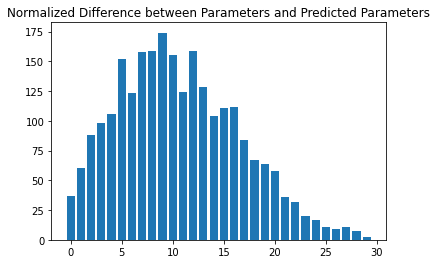

In [ ]:
#Computer SAD between  parameters in data and test parameters
hist = torch.histc(torch.sum(sad_values, dim = 1), bins = 30)
plt.bar(range(30), hist)
plt.title("Normalized Difference between Parameters and Predicted Parameters")


VAL: tensor([7266])
YHAT: tensor([100.,  21.,   0.,   0.,   0.,   0.,   1.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.])
CHECK: tensor([[100.,  21.,   0.,   0.,   0.,   0.,   1.,   0.,   0.,   0.,   0.,   0.,
           0.,   0.]])
VAL: tensor([27063])
YHAT: tensor([90., 25.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.])
CHECK: tensor([[90., 25.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.]])
VAL: tensor([1604])
YHAT: tensor([480.,  38.,   0.,   0.,   0.,   0.,   0.,   1.,   0.,   0.,   0.,   0.,
          0.,   0.])
CHECK: tensor([[480.,  38.,   0.,   0.,   0.,   0.,   0.,   1.,   0.,   0.,   0.,   0.,
           0.,   0.]])
VAL: tensor([2392])
YHAT: tensor([300.,  42.,   0.,   0.,   0.,   0.,   0.,   1.,   0.,   0.,   0.,   0.,
          0.,   0.])
CHECK: tensor([[300.,  42.,   0.,   0.,   0.,   0.,   0.,   1.,   0.,   0.,   0.,   0.,
           0.,   0.]])
VAL: tensor([], dtype=torch.int64)
YHAT: tensor([360.,  35.,   0.,   0.,   0.,   0.,   0.,  

In [ ]:
not_in_data = []
same_params_uids = []
pred_in_data = {"laser_params": [], "emissivity": [], "uids": []}
test_in_data = {"laser_params": [], "emissivity": [], "uids": []}

if substrate == 'steel':
        wave, emiss, laser_params, uids = get_data(SS_DATA_PATH, "trainval")
        wave_test, emiss_test, laser_params_test, uids_test = self.get_data(SS_DATA_PATH, "test")
else:
        wave, emiss, laser_params, uids = self.get_data(INC_DATA_PATH, "trainval")
        wave_test, emiss_test, laser_params_test, uids_test = self.get_data(INC_DATA_PATH, "test")

#[]#torch.tensor(type = "torch.float32")
for i in range(len(y_hat)):
        print(f'LEN INPUT: {len(y_hat)}')
        val = torch.all(laser_params == y_hat[i], axis=1).nonzero().flatten()
        if len(val) == 0:
                not_in_data.append(y_hat[i])
        else:
        #if the predicted parameters = the original parameters
                same_params = torch.all(torch.eq(y_hat[i], laser_params_test[i])).item()
                if same_params:
                        same_params_uids.append(uids[val])
                #if the predicted != original parameters, add to two separate dictionaries
                else:
                        pred_in_data["laser_params"].append(laser_params[val])
                        pred_in_data["emissivity"].append(emiss[val])
                        pred_in_data["uids"].append(uids[val])
                        test_in_data["laser_params"].append(laser_params_test[i])
                        test_in_data["emissivity"].append(emiss_test[i])
                        test_in_data["uids"].append(uids_test[i])
#list of tensors --> tensors
not_in_data = torch.stack(not_in_data)

In [ ]:
print(len(not_in_data))
print(len(same_params_uids))
print(len(y_hat_in_data))

567
5
2471


In [ ]:
torch.all(all_params == not_in_data, axis=1).nonzero().flatten()

tensor([[360.,  35.,   0.,   0.,   0.,   0.,   0.,   1.,   0.,   0.,   0.,   0.,
           0.,   0.]])

In [ ]:
to_minok = predictor.clean_to_minok(not_in_data)
torch.unique(to_minok, dim = 1)
#len(set(not_in_data))

tensor([[  0.7000,  35.0000, 360.0000],
        [  0.7000,  37.0000, 350.0000],
        [  0.7000,  40.0000, 380.0000],
        ...,
        [  0.7000,  36.0000, 310.0000],
        [  0.7000,  35.0000, 340.0000],
        [  0.7000,  38.0000, 370.0000]])

In [ ]:
#PUT SS PREDICTIONS INTO 3 BUCKETS !!!!!!!! 
wave_test, emiss_test, laser_params = get_test_data(f"{data_folder}/steel-onehot.pt")
steel_emiss = torch.load(Path(f"{data_folder}/steel-onehot.pt"))["emissivity"]
ss_to_minok = []
ss_in_data_same_params = []
ss_in_data_diff_params = []
watts = [0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 1.1, 1.2, 1.3]
y_add = torch.empty(3, dtype=torch.float32)
for i in range(50):#len(emiss_test)):
    predictor = Predictor(emiss_test[i].reshape(1,800), include_inconel, include_stainless, round_laser_params = True)
    y_hat_ss, y_hat_inc = predictor.run_inverse(predictor.desired)
    #predictor.denormalize_decode_result()
        # direct_ss_emiss_y_hat, direct_inc_emiss_y_hat = predictor.run_direct(y_hat_ss, y_hat_inc)
        # best_substrate, best_params, best_rmse = predictor.best_predictor(True, True, direct_ss_emiss_y_hat, direct_inc_emiss_y_hat, predictor.desired)
    y_final = predictor.denorm_result(y_hat_ss, predictor.ss_max_speed, predictor.ss_max_spacing, predictor.ss_min_speed, predictor.ss_min_spacing) #reround laser parameters
    y_final, y_index = predictor.find_in_data(y_final) #get index of laser parameters matching in original data
    print(y_final)
    print(steel_params[y_index])
    if y_index == -1:
        watt_arg = torch.argmax(y_final[0][2:])
        y_add[0] = y_final[0][0]#(max_speed - min_speed) * (y_hat[0][0] + min_speed) # TODO call the scale
        y_add[1] = y_final[0][1]#(max_spacing - min_spacing) * (y_hat[0][1] + min_spacing) # TODO call the scale
        y_add[2]= watts[watt_arg]
        ss_to_minok.append(y_add)
    else:
    #     if torch.equal(y_final, steel_params[y_index]):
    #     #print(y_final)
    #     #print(steel_params[y_index])
    #     ss_in_data_same_params.append(steel_emiss[y_index])
    # else:
        ss_in_data_diff_params.append(steel_emiss[y_index])
print(len(ss_to_minok))
#print(len(ss_in_data_same_params))
print(len(ss_in_data_diff_params))


In [ ]:
ss_to_minok

In [ ]:
y_index

In [ ]:
y_hat_ss

In [ ]:
y_final, y_index

In [ ]:
# stain_data = torch.load(
#                     Path(filepath))#["laser_params"] #stainless-steel-revised-shuffled inconel-revised-raw-shuffled
# wave_data = stain_data["interpolated_wavelength"]
# emiss_data = stain_data["interpolated_emissivity"]
# laser_params = stain_data["laser_params"]
# def check_params_in_data(filepath):
#     stain_data = torch.load(
#                     Path(filepath))#["laser_params"] #stainless-steel-revised-shuffled inconel-revised-raw-shuffled
#     wave_data = stain_data["interpolated_wavelength"]
#     emiss_data = stain_data["interpolated_emissivity"]
#     laser_params = stain_data["laser_params"]
    
#     return wave_test, emiss_test, laser_params
# laser_params
#torch.nonzero(y_final[0] == steel_params.sum(dim=1)==steel_params.size(1))
i = 0
found_index = -1
for comb in steel_params:
    i += 1
    if torch.all(torch.eq(comb, y_final)):
        found_index = i
#y_final in steel_params

found_index

In [ ]:
# inc_params = torch.load(
#                 Path(f"{data_folder}/inconel-onehot.pt"))["emissivity"]
steel_emiss = torch.load(Path(f"{data_folder}/stainless.pt"))#["emissivity"]

steel_emiss.keys()

In [ ]:
steel_params["interpolated_emissivity"]

In [ ]:
torch.isin()y_final

In [ ]:

def is_in_data(self, rounded_y_hat, ):
        indices_have_in_data
        indices_not_have_in_data
        return rounded_y_hat, indices_have_in_data, indeces_not_have_in_data

# Inverse

In [ ]:
inverse_ss_filepath = Path(f"{work_folder}/saved_best/I-1-res-ann-stainless.ckpt") #CHANGEME
inverse_inc_filepath = Path(f"{work_folder}/saved_best/I-1-res-ann-inconel.ckpt") #CHANGEME
print(inverse_ss_filepath)
print(inverse_inc_filepath)
if not Path.is_file(inverse_ss_filepath):
    raise Exception(f'Model file does not exist at {inverse_ss_filepath}!')
if not Path.is_file(inverse_inc_filepath):
    raise Exception(f'Model file does not exist at {inverse_inc_filepath}!')

In [ ]:
def get_test_data(filepath):
    stain_data = torch.load(
                    Path(f"{data_folder}/{filepath}"))#["laser_params"] #stainless-steel-revised-shuffled inconel-revised-raw-shuffled
    wave_data = stain_data["interpolated_wavelength"]
    emiss_data = stain_data["interpolated_emissivity"]
    laser_params = stain_data["laser_params"]#.keys()#["wavelenght"]
    #print(wave_test.max(1), wave_test.min(1)) #2.5002, 11.9479
    #print(emiss_test.max(1)[0])#.max(1), emiss_test.min(1)) #0, 1
    wave_test = wave_data[round(len(wave_data) * .9):]  
    emiss_test = emiss_data[round(len(wave_data) * .9):]
    return wave_test, emiss_test, laser_params
#print(max_wave, min_wave)

In [ ]:
# pass test data into inverse model, get predicted parameters
from src.models import InverseModel
i_model = InverseModel.load_from_checkpoint(inverse_ss_filepath, strict=False)
i_model.eval()

wave_test, emiss_test, laser_params = get_test_data('stainless-steel-revised-shuffled.pt')

test_y_hats = []#torch.empty(size = len(emiss_test))
for emiss in emiss_test:
    with torch.no_grad():
        test_y_hats.append(i_model(emiss.reshape(1, 800)))

In [ ]:
laser_test = laser_params
max_speed, max_spacing = laser_test.max(0)[0][0].item(), laser_test.max(0)[0][1].item()
min_speed, min_spacing = laser_test.min(0)[0][0].item(), laser_test.min(0)[0][1].item()
laser_output = [denormalize_decode_result(x.reshape(1,14), max_speed, max_spacing, min_speed, min_spacing) for x in laser_test]

# denormalize_decode_result(laser_test[3].reshape(1,14),max_speed, max_spacing, min_speed, min_spacing)

# Direct Model

In [ ]:
from src.models import DirectModel
direct_filepath = Path(""
    f"{work_folder}/saved_best/D-1-res-ann-stainless.ckpt") #CHANGEME
print(direct_filepath)
if not Path.is_file(direct_filepath):
    raise Exception(f'Model file does not exist at {direct_filepath}!')

In [ ]:
d_model = DirectModel.load_from_checkpoint(direct_filepath)
d_model.eval()
emiss_y_hats = []
for x in test_y_hats:
    with torch.no_grad():
        emiss_y_hats.append(d_model(x.reshape(1,14)))

In [ ]:
#calculate rmse
pred_rmse_vals = []
columns = ["wavelength", "emissivity", "prediction", "example_number", "laser_params"]
viz_coords = pd.DataFrame(columns = columns)
for i in range(9):#len(emiss_test)):
    pred_rmse_vals.append(rmse(emiss_y_hats[i], emiss_test[i]).item())
    for j in range(len(wave_test[i].tolist())):
        viz_coords.append([wave_test[i].tolist()[j], emiss_test[i].tolist()[j], "True", i, laser_output[i].tolist()])
        viz_coords.append([wave_test[i].tolist()[j], emiss_y_hats[i].flatten().tolist()[j], "Prediction", i, laser_output[i].tolist()])
stdev = np.std(pred_rmse_vals)
print(f'Direct Filepath: {direct_filepath}')
print(f'Inverse Filepath: {inverse_ss_filepath}')
print(f'SD of RMSEs on test data: {stdev}')


In [ ]:
alt.Chart(viz_coords).mark_line().encode(
    x='wavelength',
    y='emissivity'
).facet(facet = 'example_number:N')#, header = 'laser_params:N')#.encode(text = 'laser_params:N').

In [ ]:
#visualize predictions vs original
